<a href="https://colab.research.google.com/github/CaseySobon/Image-classification/blob/main/Cat_vs_dog_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/test1.zip'

!mkdir test1/images
!find test1 -maxdepth 1 -type f | xargs -I{} mv {} test1/images

In [ ]:
!unzip '/content/drive/MyDrive/train.zip'

!mkdir train/{dog,cat}
!find train -maxdepth 1 -type f | grep 'dog' | xargs -I{} mv {} train/dog
!find train -maxdepth 1 -type f | grep 'cat' | xargs -I{} mv {} train/cat

Archive:  /content/drive/MyDrive/train.zip
  inflating: train/cat.0.jpg         
replace __MACOSX/train/._cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: mkdir: cannot create directory ‘train/dog’: File exists
mkdir: cannot create directory ‘train/cat’: File exists
^C


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications, layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import optimizers
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.applications import ResNet50
from sklearn.metrics import confusion_matrix,classification_report
from keras.optimizers import Adam

import os
import glob
import numpy as np
import pandas as pd

from PIL import Image
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import graphviz
import plotly
import plotly.express as px
from keras.utils import plot_model
import seaborn as sb

In [ ]:
train_dir = './train'
total_train = len(os.listdir('./train/dog')) + len(os.listdir('./train/cat'))
total_test = len(os.listdir('./test1/images/'))
validation_split = 0.2

batch_size = 128
epochs = 10
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           validation_split=validation_split)

train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            class_mode='binary',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            subset='training')
val_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            class_mode='binary',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            subset='validation')



Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
#build the Resnet model
resnet = ResNet50(weights='imagenet',
                      input_shape= (224,224,3),
                      include_top= False)


In [ ]:

for layer in resnet.layers[:15]:
    layer.trainable = False

for layer in resnet.layers[15:]:
    layer.trainable = True

last_layer = resnet.get_layer('conv5_block3_out')
last_output = last_layer.output

In [ ]:
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='softmax')(x)

model = Model(resnet.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learn_rater=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
    steps_per_epoch=(total_train * (1 - validation_split) // batch_size),
    validation_steps=(total_train * validation_split // batch_size)
)


Epoch 1/10
156/156 [==============================] - 238s 1s/step - loss: 0.7036 - accuracy: 0.8754 - val_loss: 0.7090 - val_accuracy: 0.4838
Epoch 2/10
156/156 [==============================] - 217s 1s/step - loss: 0.1881 - accuracy: 0.9545 - val_loss: 0.9043 - val_accuracy: 0.5154
Epoch 3/10
156/156 [==============================] - 216s 1s/step - loss: 0.1151 - accuracy: 0.9680 - val_loss: 1.7712 - val_accuracy: 0.4860
Epoch 4/10
156/156 [==============================] - 217s 1s/step - loss: 0.0846 - accuracy: 0.9736 - val_loss: 4.3664 - val_accuracy: 0.4942
Epoch 5/10
156/156 [==============================] - 217s 1s/step - loss: 0.0585 - accuracy: 0.9816 - val_loss: 2.7563 - val_accuracy: 0.5833
Epoch 6/10
156/156 [==============================] - 217s 1s/step - loss: 0.0470 - accuracy: 0.9841 - val_loss: 0.4439 - val_accuracy: 0.8708
Epoch 7/10
156/156 [==============================] - 216s 1s/step - loss: 0.0371 - accuracy: 0.9871 - val_loss: 0.1213 - val_accuracy: 0.9651

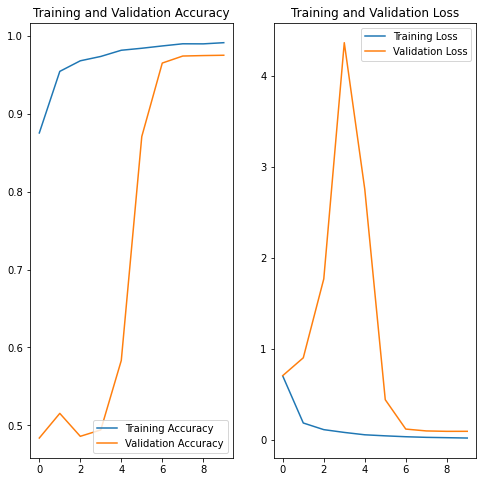

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(directory='./test1/',
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            shuffle=False,
                                            class_mode=None,
                                            batch_size=1)

Found 12500 images belonging to 1 classes.


In [ ]:
test_data_gen.reset()
predictions = model.predict(test_data_gen,
                            steps=total_test,
                            verbose=1)

12500/12500 [==============================] - 143s 11ms/step


In [ ]:
train_data_gen.class_indices

{'cat': 0, 'dog': 1}

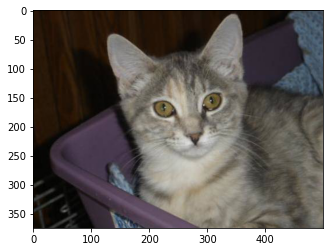

[1.]


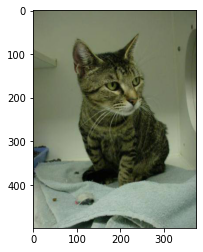

[0.]


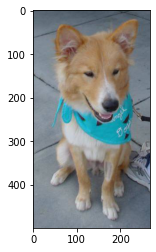

[0.]


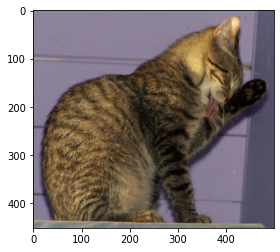

[1.]


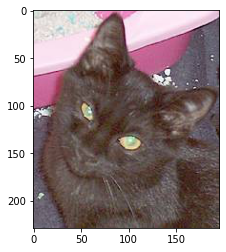

[1.]


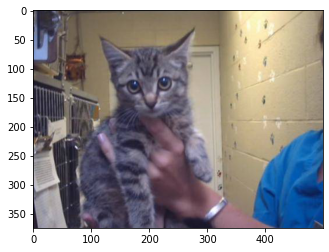

[0.]


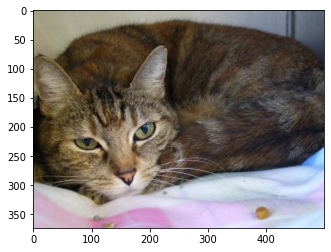

[0.]


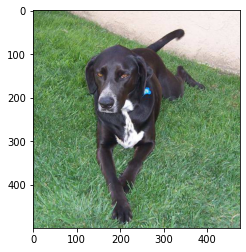

[1.]


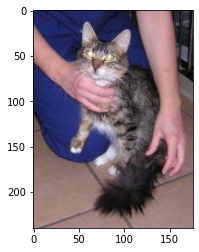

[1.]


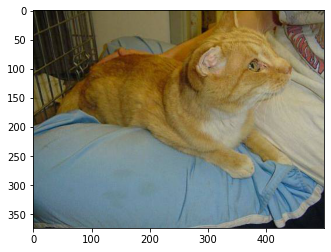

[0.]


In [ ]:
test_path = pathlib.Path('./test1/images')
paths = [str(f) for f in test_path.glob('*')]
for path, pred in list(zip(paths, np.round(predictions)))[:10]:
  plt.imshow(Image.open(path))
  plt.show()
  print(pred)

In [ ]:
def extract_test_id(path):
   file = path.split('/')[1]
   return file.split('.')[0]

test_ids = [extract_test_id(f) for f in test_data_gen.filenames]

In [ ]:
zipped = zip(test_ids, np.round(predictions.flatten()))
records = sorted(list(zipped), key=lambda kv: int(kv[0]))

In [ ]:
output = pd.DataFrame.from_records(records, columns=['id', 'label'])
output.to_csv('submission_Resnet50.csv', index=False)